# Multi energy districts - Model

***&copy; 2023 Martínez Ceseña<sup>1</sup> and Mancarella<sup>2</sup> — <sup>1,2</sup>University of Manchester, UK, and <sup>2</sup>University of Melbourne, Australia***

This is one of the documents in a series of jupyter notebooks which presents a general formulation to optimise the operation of multi-energy districts (MED). These systems bring together one or more Multi-energy system (MES) which can exchange flows through different networks (e.g., electricity, heat and gas). 

This particular notebook will focus on modelling a single MED connected to the power system under steady-state conditions. This system configuration will be used to demonstrate that, due to their flexibility, MED can provide services such as voltage support. For more details about the models presented here, and more complex tools which consider multiple MED and integrated electricity-heat-gas networks, refer to the following literature:

1. E. A. Martínez Ceseña, E. Loukarakis, N. Good and P. Mancarella, "[Integrated Electricity-Heat-Gas Systems: Techno-Economic Modeling, Optimization, and Application to Multienergy Districts](https://ieeexplore.ieee.org/document/9108286)," in Proceedings of the IEEE, Vol. 108, pp. 1392 –1410, 2020.

1. E. A. Martínez Ceseña and P. Mancarella, “[Energy systems integration in Smart districts: Robust optimisation of multi-energy flows in integrated electricity, heat and gas networks](https://ieeexplore.ieee.org/document/8340876),” IEEE Transactions on Smart Grid, vol. 10, no. 1, pp. 1122 –1131, 2019.

1. E. A. Martínez Ceseña, T. Capuder and P. Mancarella, “[Flexible distributed multi-energy generation system expansion planning under uncertainty](https://ieeexplore.ieee.org/document/7064771),” IEEE Transactions on Smart Grid, Vol. 7, pp. 348 –357, 2016.

1. T. Capuder, P. Mancarella, "[Techno-economic and environmental modelling and optimization of flexible distributed multi-generation options](https://www.sciencedirect.com/science/article/pii/S0360544214005283)," Energy, Vol. 71, pp. 516-533, 2014.

1. G. Chicco, S. Riaz, A. Mazza and P. Mancarella, "[Flexibility From Distributed Multienergy Systems](https://ieeexplore.ieee.org/document/9082595)," in Proceedings of the IEEE, Vol. 108, pp. 1496-1517, 2020.

1. E. Corsetti, S. Riaz, M. Riello, P. Mancarella, “[Modelling and deploying multi-energy flexibility: The energy lattice framework](https://www.sciencedirect.com/science/article/pii/S2666792421000238)”, Advances in Applied Energy, Vol. 2, 2021.

## List of contents

- [Background](#Background)
- [Power network model](#Power-network-model)
- [Multi energy system](#Multi-energy-system)
- [Connecting the MED and the power network](#Connecting-the-MED-and-the-power-network)
- [Iterative model](#Iterative-model)
  - [Selection of the model](#Selection-of-the-model)
  - [First iteration](#First-iteration)
  - [Second iteration](#Second-iteration)
  - [Full model](#Full-model)

[Back to top](#Multi-energy-districts---Model)

## Before we begin

Before we begin, be aware that, to benefit the most from this notebook, you will need a basic understanding of: 
- [Newton's method](https://www.sciencedirect.com/topics/mathematics/newtons-method), which is the method used in this notebook.
- [Linear programming](https://realpython.com/linear-programming-python/) (LP) models, which are the types of models presented below.
- [Python](https://www.python.org/), which is the language used in this notebook.
- The [pyomo](https://pyomo.readthedocs.io/en/stable/index.html) library, which is the optimisation software used to solve the examples in this notebook.

This notebook requires the following python libraries to work:

In [10]:
import pyomo.environ as pyo
import nbimporter
import copy
import numpy as np
import ipywidgets as widgets
from ipywidgets import interact

In addition, several tools developed in other notebooks are needed, specifically:
- [Integrated networks modelling - Electricity](./Integrated%20networks%20modelling%20-%20Electricity.ipynb)
- [Multi-energy generation systems - Example with cogeneration](./Multi-energy%20generation%20systems%20-%20Example%20with%20cogeneration.ipynb)

In [12]:
# From the notebook titled: Multi-energy generation systems - Example with cogeneration
mes_CoG = __import__('Multi-energy generation systems - Example with cogeneration')
build_MES_Cogeneration_Model = mes_CoG.build_MES_Cogeneration_Model
plot_MES = mes_CoG.plot_MES
sankey_MES_Cogeneration = mes_CoG.sankey_MES_Cogeneration
flexibility_MES_Cogeneration = mes_CoG.flexibility_MES_Cogeneration
build_MES_CG = mes_CoG.build_MES_CG

# From the notebook titled: 'Integrated networks modelling - Electricity'
Power_Network = __import__('Integrated networks modelling - Electricity')
Elec_Model = Power_Network.Elec_Model

[Back to top](#Multi-energy-districts---Model)

## Background

The aim of this notebook is to review the modelling requirements, and produce a tool, to simulate multi energy systems connected to the power system as those shown in Figure 1.

In principle, the multi energy systems can correspond to individual buildings connected to the power distribution netwwork trhough their individial building points of connections (POC) which are usually the power meters. However, the multi energy systems can represent MED comprising the aggregated multi energy buildings with (or without) explicit consideration of the distribution network, which then connect to the district's (or community's) point of connection to the high voltage subsation (e.g., transmission network substation). The same type of modelling can then be used to represent interconnectes areas, cities, etc.

Add Figure


![MED_Network.png](Figures/MED_Network.png "Title")
<center><b>Figure 1. </b>Representation of multi energy systems connected to a power network.</center>

Regardless of the type of multi-energy system under consideration (e.g., MED, building, etc.) the building blocks required to model the system are roughly the same (see Figure 2) [1][2]. We will develop a similar framework to model MED in this notebook.

<img src="Figures/District_MES.png" alt="fishy" class="bg-primary" width="400px">
<center><b>Figure 2. </b>District MES modelling framework [1][2].</center>

To develop a similar model as that presented in Figure 2, we will need to develop:
- A power network model. This model will replace the Integrated electricity-heat-gas mnodel block in the figure
- A MED model. This model will replace the MILP model shown in the figure
- An iterative approach to make the network and MED models converge

Each of these components will be discussed in detail below.

[Back to top](#Multi-energy-districts---Model)

## Power network model

Let us begin with by modelling a small network which may be connected to a MED, some demands and generators as shown in Figure 3. The MED is being treated as a black box here, but in practice, it can comprise multiple buildings and networks which could be explicitly modelled if required.
> We will simulate the network using the model developed in [Integrated networks modelling - Electricity](./Integrated%20networks%20modelling%20-%20Electricity.ipynb). Please check the notebook if the next sections are unclear.

![Power_Network_3Bus_MED.png](Figures/Power_Network_3Bus_MED.png)
<center><b>Figure 3. </b>Example 3-bus power network connected to MED.</center>

It is assumed that the characteristics of the power system are as follows:

In [25]:
Elec_Net = {}
Elec_Net['Connectivity'] = np.array([[1, 2], [1, 3], [2, 3]])
Elec_Net['R'] = [1, 1, 1]  # [pu]
Elec_Net['X'] = [3, 3, 3]  # [pu]

For the time being, let us assume the MED is self supplying, so its power injections are zero. The only power injections considered would be due to the loads and the slack generator.

In [27]:
Elec_Net['Demand_Active'] = [0, 3.5, 3.5]  # [MW]
Elec_Net['Demand_Reactive'] = [0, 1.5, 1.5]  # [MVAr]
Elec_Net['Generation_Active'] = [0, 0, 0]  # [MW]
Elec_Net['Generation_Reactive'] = [0, 0, 0]  # [MVAr]

Based on the figure, the slack generator is assumed to be in bus 3.

In [29]:
Elec_Net['Slack_Bus'] = 3 

Now that we have defined the conditions of the power system, its steady state flows can be simulated:

In [31]:
mod = Elec_Model(Elec_Net)
mod.run()
mod.display()

VOLTAGES  [pu] [deg]:
 1)   0.9697 +j  -0.0300 (  0.9702 ∠  -1.7720)
 2)   0.9394 +j  -0.0600 (  0.9413 ∠  -3.6546)
 3)   1.0000 +j   0.0000 (  1.0000 ∠   0.0000)
CURRENTS [pu] [deg]:
 1- 2)   0.0120 +j  -0.0061 (  0.0135 ∠ -26.8532)
 1- 3)  -0.0120 +j   0.0061 (  0.0135 ∠ 153.1468)
 2- 3)  -0.0241 +j   0.0122 (  0.0270 ∠ 153.1468)
POWER  [MVA]:
      From:                To:                   Loss:
 1- 2)   1.1848 +j   0.5545  -1.1667 +j  -0.5000 (  0.0182 +j   0.0545)
 1- 3)  -1.1848 +j  -0.5545   1.2030 +j   0.6091 (  0.0182 +j   0.0545)
 2- 3)  -2.3333 +j  -1.0000   2.4061 +j   1.2182 (  0.0727 +j   0.2182)


The power network seems to be operating within its statutory limits. Although the voltage in node two is close to the lower limit (0.94 pu). This implies that there may be low voltage issues once the operation of the MED is considered.

> The next step is to model the operation of the MED.

[Back to top](#Multi-energy-districts---Model)

## Multi energy system

As mentioned above, the MED can be modelled in terms of the different buildings and networks within it. For the sake of simplicity, we will use an aggregated representation of the system (without networks) as was done in [3]. For this purpose, we will assume the aggregated MED configuration presented in Figure 4.

> We will model this multi-energy system with the tool developed in [Multi-energy generation systems - Example with cogeneration](./Multi-energy%20generation%20systems%20-%20Example%20with%20cogeneration.ipynb). Please check the notebook if the next sections are unclear.

![MES_cogeneration.png](Figures/MES_cogeneration.png)
<center><b>Figure 4. </b>Assumed MED configuration - MES with cogeneration.</center>

Based on the selected modelling tool, the MED can be represented by:
- Creating the multi-energy system object and selecting the number of periods and duration of the periods for the simulation (only one period in this example)

In [38]:
# Setting pyomo model and number of periods to optimise
lp_model = pyo.ConcreteModel()
lp_model.Set_Periods = range(1)
lp_model.dt = 1

- Defining the aggregated energy demands within the MED

In [40]:
# Demands
lp_model.Electricity_Demand = [1]  # [MW]
lp_model.Heat_Demand = [3]  # [MW]

- Defining the capacities and efficiences of every distributed energy resource

In [42]:
# DER
lp_model.Boiler_Heat_Capacity = 3  # [MW]
lp_model.Boiler_Heat_Efficiency = 0.85  # [pu]

lp_model.EHP_Heat_Capacity = 3  # [MW]
lp_model.EHP_Heat_Efficiency = 3  # [pu]

lp_model.CHP_Heat_Capacity = 3  # [MW]
lp_model.CHP_Electricity_Efficiency = 0.35  # [pu]
lp_model.CHP_Heat_Efficiency = 0.45  # [pu]

- Adding the energy prices and penalties.

In [44]:
# Prices and penalties
lp_model.Electricity_Import_Price = [0.1]  # [£/MWh]
lp_model.Electricity_Export_Price = [0.01]  # [£/MWh]
lp_model.Gas_Import_Price = [0.1]  # [£/kWh]

lp_model.Heat_Spill_Penalty = [0]  # [£/kWh]
lp_model.Heat_Shedding_Penalty = [1000]  # [£/kWh]

The tool then provides several methods to solve the model and visualize the results.

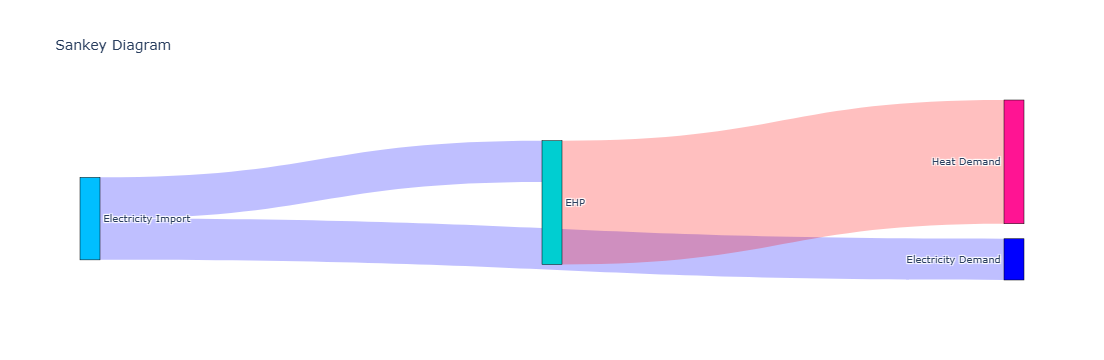

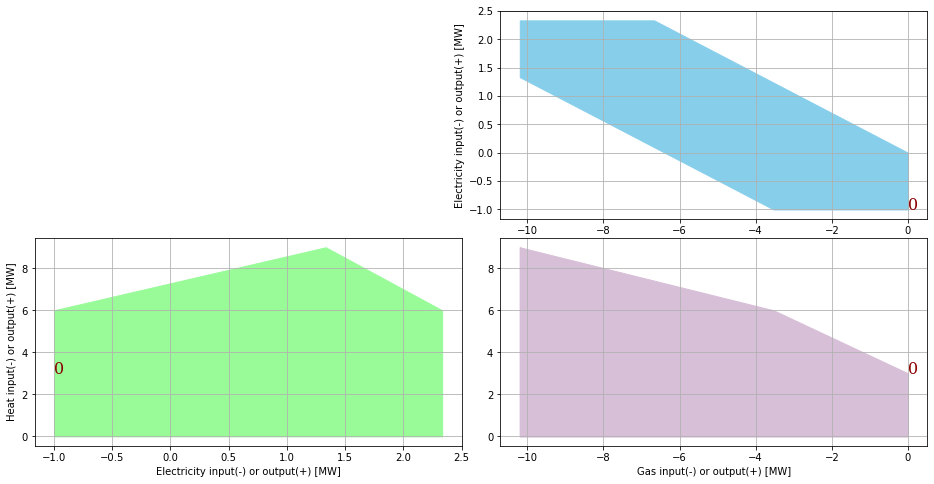

In [144]:
# Building and solving model
model = copy.deepcopy(lp_model)  # Making a copy for later use
results = build_MES_Cogeneration_Model(model)


# Visualizing model
sankey_MES_Cogeneration(model)

flexibility_MES_Cogeneration(model, True, True, True,
                             'Electricity input(-) or output(+) [MW]',
                             'Heat input(-) or output(+) [MW]',
                             'Gas input(-) or output(+) [MW]')

[Back to top](#Multi-energy-districts---Model)

## Connecting the MED and the power network

Now that we have modelled the operation of the MED, we can determine its contribution to the power grid. For that purpose, we will use the configuration shown in Figure 5. Note that a linear programming (LP) model is used to simulate the MED.

<img src="Figures/District_MES_Straight.png" alt="fishy" class="bg-primary" width="400px">
<center><b>Figure 5. </b>Non iterative district MES modelling framework.</center>

Building on the figure above, the the power injections of the MED should be passed to the power network model.

In [52]:
opt = model.Electricity_Export[0].value-model.Electricity_Import[0].value
if opt > 0:
    print('The MED is exporting %.2f [MW] to the grid.'%opt)
else:
    print('The MED is importing %.2f [MW] from the grid.'%-opt)

The MED is importing 2.00 [MW] from the grid.


In addition to the MED power injections to or from the grid, we also need to define the point of connection to the power network, as well as the PF. In addition, we can have aflag for the number of MED which will be modelled (set to one in this example). For the sake of convenience, the information is stored in a python object.

In [54]:
Dis = {}
Dis['Elec'] = {}
Dis['Elec']['Location'] = [1] # Connection to power system,
Dis['Elec']['Output'] = [opt] # MW
Dis['Elec']['PF'] = [1]
Dis['Elec']['Number'] = 1

Now that the MED information has been defined, it can be added to the network data as power injections in the relevant node. This information is then passed to the network simulator.

In [56]:
def simulateDistrict(Dis, Elec_Network, Elec_Model):
    ''' Simulate system with current MES output '''
    # Copy data - to be used for later
    ENet = copy.deepcopy(Elec_Network)
    
    # Simulate system with current MED flows
    for d in range(Dis['Elec']['Number']):
        b = Dis['Elec']['Location'][d]-1  # Get relevant bus

        # Get power contribution of MED
        P = Dis['Elec']['Output'][d]
        S = P/Dis['Elec']['PF'][d]
        Q = (S**2-P**2)**0.5

        ENet['Generation_Active'][b] = (Elec_Network['Generation_Active'][b] + P)
        ENet['Generation_Reactive'][b] = (Elec_Network['Generation_Reactive'][b] + Q)

    # creating network simulation object
    mod = Elec_Model(ENet)
    mod.run()
    
    # Add relevant district information
    mod.parameters['Dis'] = {}
    mod.parameters['Dis']['Outputs'] = Dis['Elec']['Output']
    mod.parameters['Dis']['PF'] = Dis['Elec']['PF']
    mod.parameters['Dis']['Location'] = Dis['Elec']['Location']
    mod.parameters['Dis']['Number'] = Dis['Elec']['Number']
    
    return mod

In [57]:
mod = simulateDistrict(Dis, Elec_Net, Elec_Model)

The result is a power network model which includes the contributions of the MED, and can simulate the steady-state conditions of the network.

In [59]:
mod = simulateDistrict(Dis, Elec_Net, Elec_Model)
mod.display()

VOLTAGES  [pu] [deg]:
 1)   0.9517 +j  -0.0704 (  0.9543 ∠  -4.2296)
 2)   0.9290 +j  -0.0796 (  0.9324 ∠  -4.8983)
 3)   1.0000 +j   0.0000 (  1.0000 ∠   0.0000)
CURRENTS [pu] [deg]:
 1- 2)   0.0050 +j  -0.0059 (  0.0078 ∠ -49.4637)
 1- 3)  -0.0259 +j   0.0074 (  0.0270 ∠ 163.9941)
 2- 3)  -0.0310 +j   0.0133 (  0.0337 ∠ 156.7097)
POWER  [MVA]:
      From:                To:                   Loss:
 1- 2)   0.5214 +j   0.5257  -0.5154 +j  -0.5076 (  0.0060 +j   0.0181)
 1- 3)  -2.5214 +j  -0.5257   2.5942 +j   0.7442 (  0.0728 +j   0.2185)
 2- 3)  -2.9846 +j  -0.9924   3.0984 +j   1.3338 (  0.1138 +j   0.3414)


It can be seen that, even though there are no network issues in the location of the MED (bus 1), there are now low voltage isses in other parts of the network (the voltage in bus 2 is lower thatn 0.94 pu). 

>There is value in using flexibility from the MED to alleviate the voltage issue.

[Back to top](#Multi-energy-districts---Model)

## Iterative model

###  Selection of the model

In order for the MED to use its flexibility to support the power network, we need to formulate the signals or constraints that would incentivise the MED to change its operation.

For this purpose, we need to select the network issue that the MED is expected to address. In this example, we select low voltage issues (lower than 0.94 pu), but other constraints can be simulated in a similar manner.

In [65]:
def getMin_Vol_Con(mod, model):
    ''' Get min voltage issues data'''
    
    # Create object to store the data
    Net_Con = {}
    Net_Con['Limit'] = 0.94  # Limit
    Otpt = model.Electricity_Export[0].value-model.Electricity_Import[0].value
    Net_Con['Output'] = []
    Net_Con['Delta'] = []

    # Looc for location and magnitude of any voltage issues
    Net_Con['Location'] = []
    Net_Con['Magnitude'] = []
    for b in range(mod.parameters['Buses']):
        val = mod.parameters['Voltage_Magnitude'][b]
        if val < Net_Con['Limit']:
            Net_Con['Location'].append(b)
            Net_Con['Magnitude'].append(Net_Con['Limit']-val)
            Net_Con['Output'].append(Otpt)
            Net_Con['Delta'].append(1000)

    Net_Con['Number'] = len(Net_Con['Magnitude'])  # Number of issues

    return Net_Con

In [66]:
Net_Con = getMin_Vol_Con(mod, model)
for x in range(Net_Con['Number']):
    print('Voltage violation in bus %d (%.4f)'%
          (Net_Con['Location'][x]+1, Net_Con['Magnitude'][x]))

Voltage violation in bus 2 (0.0076)


This information provides the voltage violation as a function of the MED operation ($f(x)$), and our aim is to identify if there is an option to adjust the MED's operation (value of $x$) which would alleviate the issue (results in $f(x) = 0$). This is the type of problems that Newton's method (or other rootfinding algorithms) can solve.

As a reminder, Newton's method can be applied by iteratively using the following equation:

$$
x_{k+1} = x_k - \frac{f(x_k)}{f'(x_k)}
$$

As we have already determined the values for $x$ and $f(x)$, we only need the value of $f'(x)$. Solving such equation algebraically may be challenging considering that the function includes the power flow model. However, it is retatively easy to solve numerically:

$$
f'(x) = \frac{\partial f(x)}{\partial x} \approx \Delta f(x) = \lim_{ \Delta x \to 0} \frac{f(x + \Delta x) - f(x)}{\Delta x}
$$

Based on this approximation $f'(x)$ can be obtained by first repeating the power flow simulation with a marginally higher output of the MED and calculating new voltage issues ($f(x + \Delta x)$). Afterwards, these results can then be compared with the simulations above which already provide $f(x)$.

This procedure is developed below:

In [73]:
def getElecDeltas(mod, Net_Con, DP = 0.01):
    '''Get deltas for voltages'''
    for d in range(mod.parameters['Dis']['Number']):
        b = mod.parameters['Dis']['Location'][d]-1  # Get relevant bus
        
        # Get power contribution of MES, including delta
        P = DP
        S = P/mod.parameters['Dis']['PF'][d]
        Q = (S**2-P**2)**0.5
        
        # Adjust contribution of MES
        md = copy.deepcopy(mod)
        md.parameters['Generation_Active'][b] += P
        md.parameters['Generation_Reactive'][b] += Q
        
        # Simulate network with adjusted values
        md.run()

        # Calculate deltas with numerical differentiation and
        # Update target output
        x = 0
        for n in Net_Con['Location']:
            delta = (md.parameters['Voltage_Magnitude'][n]-
                     mod.parameters['Voltage_Magnitude'][n])/DP
            aux = Net_Con['Magnitude'][x]/delta
            Net_Con['Delta'][x] = min(abs(aux), Net_Con['Delta'][x])
            Net_Con['Output'][x] += aux
            x += 1

In [74]:
getElecDeltas(mod, Net_Con)
print('The estimated value of Δf is:', Net_Con['Delta'])

The estimated value of Δf is: [1.5502262483146323]


> It is now time to pass this information to the MED simulation model to incentivise it to change its output.

[Back to top](#Multi-energy-districts---Model)

### First iteration

Let us take the MED data and build again its LP model. 

In [79]:
model = copy.deepcopy(lp_model)
build_MES_CG(model)

Instead of running the model, we will add information about the network constraints, as well as a new variable for the MED to decide whether or not to alleviate the constraint.

In [81]:
model.Net_Con = Net_Con
model.Set_Con = range(Net_Con['Number'])

model.Con_Violation = \
    pyo.Var(model.Set_Con, domain=pyo.NonNegativeReals)

Newton's correction factor is then added as a soft constraint, as the MED can still refuce to reduce the voltage constraint violation to zero

In [83]:
def Network_Con_rule(model, con, period):
    return model.Con_Violation[con] >= model.Net_Con['Output'][con] - \
        model.Electricity_Export[period] + model.Electricity_Import[period]

model.Con_Net_Con = pyo.Constraint(model.Set_Con, model.Set_Periods,
                                   rule=Network_Con_rule)

In order to tighten the constraint, a penalty for keeping the constraint violation above zero is introduced. In practice this penalty could represent a price signal sent to the MED to incentivise it to alleviate the constraint violation. 

If the network constraint is binding (e.g., the MED is contractually obligated to provide the service), the penalty can be increase ot a value significantly higher than the energy prices (as done here). In such a case, the MED will alleviate the constraint as long as it is technically feasible.

In [85]:
def Objective_rule(model):
    penalty = 1000
    costs = 0
    for period in model.Set_Periods:
        costs += (model.Electricity_Import[period] *
                  model.Electricity_Import_Price[period] +
                  model.Gas_Import[period] *
                  model.Gas_Import_Price[period] -
                  model.Electricity_Export[period] *
                  model.Electricity_Export_Price[period] +
                  model.Heat_Spill[period] *
                  model.Heat_Spill_Penalty[period] +
                  model.Heat_Shedding[period] *
                  model.Heat_Shedding_Penalty[period] +
                  sum(model.Con_Violation[x] for x in model.Set_Con)*penalty
                 )*model.dt
    return costs

In [86]:
model.Objective_Function = pyo.Objective(rule=Objective_rule)

The MED operation can now be simulated and visualized.

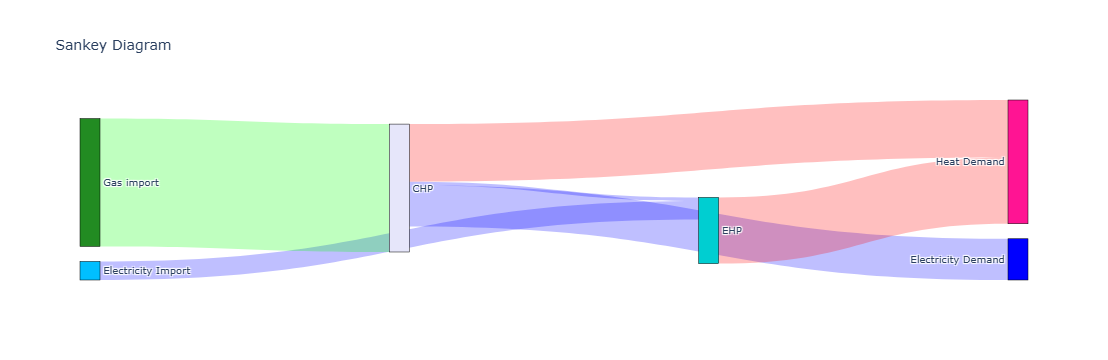

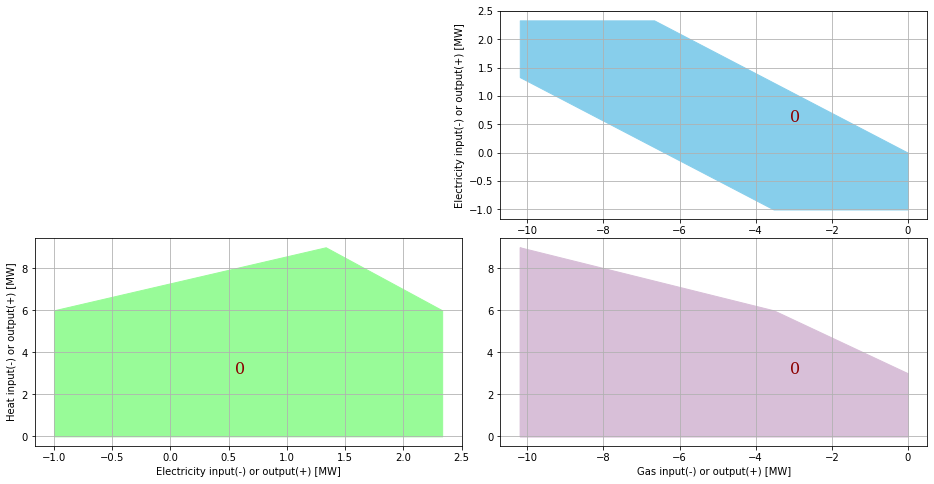

In [88]:
# Simulating model
results = pyo.SolverFactory('glpk').solve(model)

# Visualizing MED operation
sankey_MES_Cogeneration(model)

flexibility_MES_Cogeneration(model, True, True, True,
                             'Electricity input(-) or output(+) [MW]',
                             'Heat input(-) or output(+) [MW]',
                             'Gas input(-) or output(+) [MW]')

We can see that the operation of the district has changed:

In [90]:
opt = model.Electricity_Export[0].value-model.Electricity_Import[0].value
if opt > 0:
    print('The MED is exporting %.2f [MW] to the grid.'%opt)
else:
    print('The MED is importing %.2f [MW] from the grid.'%-opt)

The MED is importing 0.45 [MW] from the grid.


Also, the network conditions have been partially addressed, but there is room for improvement:

In [92]:
Dis['Elec']['Output'] = [opt] # MW
mod = simulateDistrict(Dis, Elec_Net, Elec_Model)
mod.display()

VOLTAGES  [pu] [deg]:
 1)   0.9660 +j  -0.0391 (  0.9668 ∠  -2.3168)
 2)   0.9372 +j  -0.0644 (  0.9395 ∠  -3.9313)
 3)   1.0000 +j   0.0000 (  1.0000 ∠   0.0000)
CURRENTS [pu] [deg]:
 1- 2)   0.0105 +j  -0.0061 (  0.0121 ∠ -30.2076)
 1- 3)  -0.0151 +j   0.0063 (  0.0164 ∠ 157.4282)
 2- 3)  -0.0256 +j   0.0124 (  0.0284 ∠ 154.1814)
POWER  [MVA]:
      From:                To:                   Loss:
 1- 2)   1.0357 +j   0.5482  -1.0210 +j  -0.5041 (  0.0147 +j   0.0441)
 1- 3)  -1.4855 +j  -0.5482   1.5123 +j   0.6286 (  0.0268 +j   0.0805)
 2- 3)  -2.4790 +j  -0.9959   2.5598 +j   1.2385 (  0.0809 +j   0.2426)


[Back to top](#Multi-energy-districts---Model)

### Second iteration

The MED has not fully addressed the voltage issue and, therefore, another iteration is needed. The difference is that we can now have constraints that are no longer binding if the MED overcompensated its response, some of the existing constraints may persist or new constraints may arise. We need to identify wll these cases:

In [96]:
def updateMin_Vol_Con(Net_Con, mod, model):
    New_Con = getMin_Vol_Con(mod, model)
    
    # Check for constraints that are no longer binding
    for xo in range(Net_Con['Number']):
        b = Net_Con['Location'][xo]
        if b not in New_Con['Location']:
            # Relax constraint
            val = mod.parameters['Voltage_Magnitude'][b]
            Net_Con['Magnitude'][xo] = Net_Con['Limit']-val

    for xn in range(New_Con['Number']):
        b = New_Con['Location'][xn]
        
        # Check constraints that are still binding
        if b in Net_Con['Location']:
            xo = Net_Con['Location'].index(b)
            Net_Con['Magnitude'][xo]=New_Con['Magnitude'][xn]
            
        else:  # Check for new constraints
            Net_Con['Location'].append(New_Con['Location'][xn])
            Net_Con['Magnitude'].append(New_Con['Magnitude'][xn])

    Net_Con['Number'] = len(Net_Con['Location'])
    getElecDeltas(mod, Net_Con)

In [97]:
print(Net_Con)
updateMin_Vol_Con(Net_Con, mod, model)

{'Limit': 0.94, 'Output': [-0.4497737516853677], 'Delta': [1.5502262483146323], 'Location': [1], 'Magnitude': [0.007592310126796731], 'Number': 1}


The procedure is repeated, i.e., new Newton correction factors are calculated and passed to the MED model.

In [99]:
def build_MED(lp_model, Net_Con, build_MES_CG):
    ''' Building MED mathematical model '''
    
    # Building model using code from previous notebook
    model = copy.deepcopy(lp_model)
    build_MES_CG(model)

    # Add parameters to represent network
    model.Net_Con = Net_Con
    model.Set_Con = range(Net_Con['Number'])

    # Add variables and constraints to model network approximation
    model.Con_Violation = \
        pyo.Var(model.Set_Con, domain=pyo.NonNegativeReals)
    model.Con_Net_Con = \
        pyo.Constraint(model.Set_Con, model.Set_Periods,
                       rule=Network_Con_rule)

    # Add revised objective function
    model.Objective_Function = pyo.Objective(rule=Objective_rule)
    results = pyo.SolverFactory('glpk').solve(model)
    opt = model.Electricity_Export[0].value-model.Electricity_Import[0].value
    
    return (results, opt, model)

(results, opt, model) = build_MED(lp_model, Net_Con, build_MES_CG)

We can see that the conditions of the network are gradually improving as the voltage in bus 2 gets closer to 0.94.

In [101]:
Dis['Elec']['Output'] = [opt] # MW
mod = simulateDistrict(Dis, Elec_Net, Elec_Model)
mod.display()

VOLTAGES  [pu] [deg]:
 1)   0.9671 +j  -0.0365 (  0.9678 ∠  -2.1602)
 2)   0.9379 +j  -0.0631 (  0.9400 ∠  -3.8518)
 3)   1.0000 +j   0.0000 (  1.0000 ∠   0.0000)
CURRENTS [pu] [deg]:
 1- 2)   0.0109 +j  -0.0061 (  0.0125 ∠ -29.1809)
 1- 3)  -0.0142 +j   0.0062 (  0.0155 ∠ 156.3819)
 2- 3)  -0.0252 +j   0.0123 (  0.0280 ∠ 153.9009)
POWER  [MVA]:
      From:                To:                   Loss:
 1- 2)   1.0785 +j   0.5500  -1.0628 +j  -0.5031 (  0.0156 +j   0.0469)
 1- 3)  -1.3993 +j  -0.5500   1.4234 +j   0.6224 (  0.0241 +j   0.0724)
 2- 3)  -2.4372 +j  -0.9969   2.5156 +j   1.2323 (  0.0785 +j   0.2354)


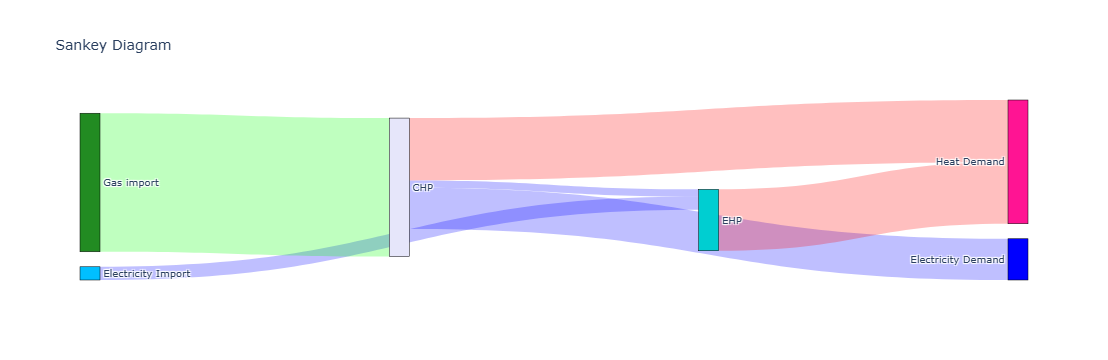

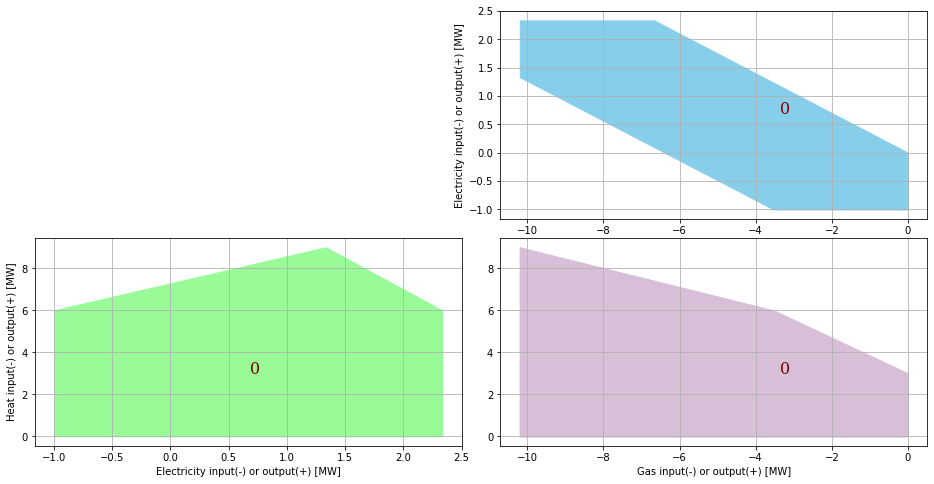

In [102]:
# Visualizing model
sankey_MES_Cogeneration(model)

flexibility_MES_Cogeneration(model, True, True, True,
                                 'Electricity input(-) or output(+) [MW]',
                                 'Heat input(-) or output(+) [MW]',
                                 'Gas input(-) or output(+) [MW]')

[Back to top](#Multi-energy-districts---Model)

### Full model

The full model is brought together in the method presented below:

In [106]:
def MED_Model(lp_model, Elec_Net, Dis, MES_Model, Elec_Model, build_MES_CG):
    # Building and solving model
    model = copy.deepcopy(lp_model)
    #results = build_MES_Cogeneration_Model(model)
    results = MES_Model(model)
    
    old_opt = model.Electricity_Export[0].value-model.Electricity_Import[0].value
    opt = copy.deepcopy(old_opt)
    Dis['Elec']['Output'] = [opt] # MW
    Dis['Elec']['Number'] = len(Dis['Elec']['Location'])
    
    # Model network under base conditions
    mod = simulateDistrict(Dis, Elec_Net, Elec_Model)    
    Net_Con = getMin_Vol_Con(mod, model)
    getElecDeltas(mod, Net_Con)

    # Check network conditions
    (results, opt, model) = build_MED(lp_model, Net_Con, build_MES_CG)
    Dis['Elec']['Output'] = [opt] # MW
    mod = simulateDistrict(Dis, Elec_Net, Elec_Model)
    
    # Iterative approach
    iter_Max = 20
    iter = 0
    if len(Net_Con['Delta']) == 0:
        print('No MED support is needed\n')
    else:
        while min(Net_Con['Delta'])>0.01:
            iter += 1
            updateMin_Vol_Con(Net_Con, mod, model)
            (results, opt, model) = build_MED(lp_model, Net_Con, build_MES_CG)
            Dis['Elec']['Output'] = [opt] # MW
            mod = simulateDistrict(Dis, Elec_Net, Elec_Model)
            
            aux = model.Electricity_Export[0].value-model.Electricity_Import[0].value
            if old_opt == aux:
                print('The MED cannot provide further support\n')
                Net_Con['Delta'] = [0]
            else:
                old_opt = copy.deepcopy(aux)

            if iter >= iter_Max:
                print('The model failed to converge after %d iterations\n'%iter)
                Net_Con['Delta'] = [0]

    return(mod, model)

[Back to top](#Multi-energy-districts---Model)